In [1]:
%reset
import os

# Change the current working directory to the desired path
os.chdir('/mnt/home/spandey/ceph/GODMAX/src/')

import numpy as np
import jax.numpy as jnp
import colossus 
from jax import vmap, grad
import matplotlib
import copy

import matplotlib.pyplot as pl
pl.rc('text', usetex=False)
# Palatino
pl.rc('font', family='DejaVu Sans')

%load_ext autoreload
%autoreload 2
%matplotlib inline





In [3]:
from colossus.cosmology import cosmology
cosmo_params_dict = {'flat': True, 'H0': 67.2, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95, 'w0':-1.0}
cosmo = cosmology.setCosmology('myCosmo', **cosmo_params_dict)
sim_params_dict = {}
sim_params_dict['nfw_trunc'] = True
sim_params_dict['theta_co'] = 0.1
sim_params_dict['theta_ej'] = 4.0
sim_params_dict['neg_bhse_plus_1'] = 0.833
sim_params_dict['mu_beta'] = 0.21
sim_params_dict['eta_star'] = 0.3
sim_params_dict['eta_cga'] = 0.6
sim_params_dict['A_starcga'] = 0.09
sim_params_dict['M1_starcga'] = 2.5e11
sim_params_dict['epsilon_rt'] = 4.0
sim_params_dict['Mc0'] = 10**14.83
# sim_params_dict['Mc0'] = 10**1
sim_params_dict['nu_z'] = 0
sim_params_dict['nu_M'] = 0
sim_params_dict['Mstar0'] = 10**13
sim_params_dict['a_zeta'] = 0.3
sim_params_dict['n_zeta'] = 2
sim_params_dict['alpha_nt'] = 0.18
sim_params_dict['beta_nt'] = 0.5
sim_params_dict['n_nt'] = 0.3
sim_params_dict['cosmo'] = cosmo_params_dict




In [32]:
halo_params_dict = {}
halo_params_dict['rmin'], halo_params_dict['rmax'], halo_params_dict['nr'] = 5e-3, 10, 64
halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.01, 2.5, 32
halo_params_dict['Mmin'], halo_params_dict['Mmax'], halo_params_dict['nM'] = 1e12, 1e15, 32
halo_params_dict['cmin'], halo_params_dict['cmax'], halo_params_dict['nc'] = 2, 10, 32
halo_params_dict['ellmin'], halo_params_dict['ellmax'], halo_params_dict['nell'] = 8, 2**15, 2048
halo_params_dict['sig_logc_z_array'] = np.ones(halo_params_dict['nz']) * 0.25
halo_params_dict['mdef'] = '200c'
halo_params_dict['hmf_model'] = 'T10'
halo_params_dict['do_corr_2h_mm'] = True
# halo_params_dict['do_corr_2h_mm'] = False



In [27]:
# 2**16


In [28]:
from astropy.io import fits
df = fits.open('/mnt/home/spandey/ceph/GODMAX/data/sim_3x2pt_simulated_DV_PKproject_values_bestfit_maglim_3x2LCDM_final.fits') 
z_array = df['nz_source'].data['Z_MID']
nz_info_dict = {}
nz_info_dict['z_array'] = z_array
nz_info_dict['nbins'] = 4
nz_info_dict['nz0'] = np.maximum(df['nz_source'].data['BIN1'], 1e-3)
nz_info_dict['nz1'] = np.maximum(df['nz_source'].data['BIN2'], 1e-3)
nz_info_dict['nz2'] = np.maximum(df['nz_source'].data['BIN3'], 1e-3)
nz_info_dict['nz3'] = np.maximum(df['nz_source'].data['BIN4'], 1e-3)
analysis_dict = {}
analysis_dict['nz_info_dict'] = nz_info_dict
analysis_dict['do_sheary'] = True
analysis_dict['do_shear2pt'] = True

df_data = fits.open('/mnt/home/spandey/ceph/GODMAX/data/DES_ACT_full_data_theorycov_2.5.fits')
theta_data = df_data['compton_shear'].data['ANG'][0:20]


analysis_dict['angles_data_array'] = jnp.array(theta_data)
analysis_dict['beam_fwhm_arcmin'] = 1.6
analysis_dict['want_like_diff'] = False


In [6]:
# from setup_power_spectra_jit import setup_power_BCMP

# setup_power_BCMP_test = setup_power_BCMP(sim_params_dict, halo_params_dict, analysis_dict, num_points_trapz_int=64)







In [7]:
# from get_power_spectra_jit import get_power_BCMP

# # get_power_BCMP_test = get_power_BCMP(sim_params_dict, halo_params_dict, setup_power_BCMP_test, num_points_trapz_int=64)
# get_power_BCMP_obj_test = get_power_BCMP(sim_params_dict, halo_params_dict, analysis_dict,setup_power_BCMP_obj=setup_power_BCMP_test, verbose_time=True)





In [16]:
# from get_corr_func import get_corrfunc_BCMP
from get_corr_func_jit import get_corrfunc_BCMP
# get_corrfunc_BCMP_test = get_corrfunc_BCMP(sim_params_dict, halo_params_dict, analysis_dict, get_power_BCMP_obj=get_power_BCMP_obj_test, verbose_time=True)
get_corrfunc_BCMP_test_T10_corr2h_mcfit = get_corrfunc_BCMP(sim_params_dict, halo_params_dict, analysis_dict, verbose_time=False)




In [17]:
from get_corr_func_jit import get_corrfunc_BCMP
import copy
halo_params_dict_nocorr2h = copy.deepcopy(halo_params_dict)
halo_params_dict_nocorr2h['do_corr_2h_mm'] = False
get_corrfunc_BCMP_test_T10_nocorr2h_mcfit = get_corrfunc_BCMP(sim_params_dict, halo_params_dict_nocorr2h, analysis_dict, verbose_time=False)


In [33]:
from get_corr_func_jit import get_corrfunc_BCMP
import copy
# halo_params_dict_nocorr2h = copy.deepcopy(halo_params_dict)
# halo_params_dict_nocorr2h['do_corr_2h_mm'] = False
analysis_dict_brute = copy.deepcopy(analysis_dict)
analysis_dict_brute['want_like_diff'] = True
get_corrfunc_BCMP_test_T10_corr2h_brute = get_corrfunc_BCMP(sim_params_dict, halo_params_dict, analysis_dict_brute, verbose_time=False)



In [19]:
# get_corrfunc_BCMP_test_T10_corr2h_brute.xip_out_mat.shape

In [20]:
# get_corrfunc_BCMP_test_T10_corr2h_mcfit.xip_out_mat.shape


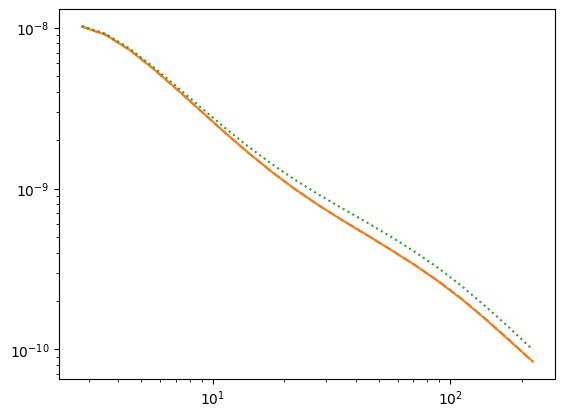

In [30]:
# get_power_BCMP_test.p_logc_Mz.shape
pl.figure()
pl.plot(get_corrfunc_BCMP_test_T10_corr2h_mcfit.angles_data_array, get_corrfunc_BCMP_test_T10_corr2h_mcfit.gty_out_mat[:,3], ls='--')
pl.plot(get_corrfunc_BCMP_test_T10_corr2h_brute.angles_data_array, get_corrfunc_BCMP_test_T10_corr2h_brute.gty_out_mat[:,3], ls='-')
pl.plot(get_corrfunc_BCMP_test_T10_nocorr2h_mcfit.angles_data_array, get_corrfunc_BCMP_test_T10_nocorr2h_mcfit.gty_out_mat[:,3], ls=':')
pl.xscale('log')
# pl.xlim(0.8,100)
# pl.ylim(0.0,2e-9)
pl.yscale('log')






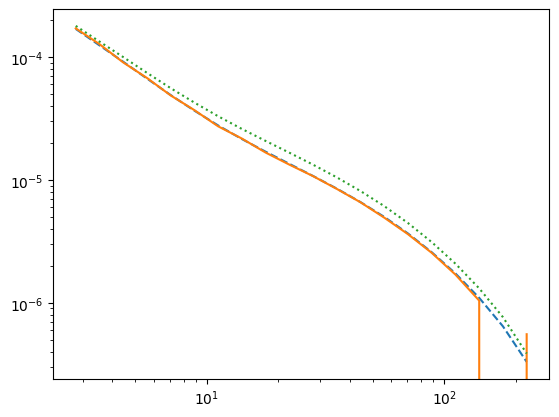

In [34]:
# get_power_BCMP_test.p_logc_Mz.shape
pl.figure()
pl.plot(get_corrfunc_BCMP_test_T10_corr2h_mcfit.angles_data_array, get_corrfunc_BCMP_test_T10_corr2h_mcfit.xip_out_mat[:,3,3], ls='--')
pl.plot(get_corrfunc_BCMP_test_T10_corr2h_brute.angles_data_array, get_corrfunc_BCMP_test_T10_corr2h_brute.xip_out_mat[:,3,3], ls='-')
pl.plot(get_corrfunc_BCMP_test_T10_nocorr2h_mcfit.angles_data_array, get_corrfunc_BCMP_test_T10_nocorr2h_mcfit.xip_out_mat[:,3,3], ls=':')
pl.xscale('log')
# pl.xlim(0.8,100)
# pl.ylim(0.0,2e-9)
pl.yscale('log')






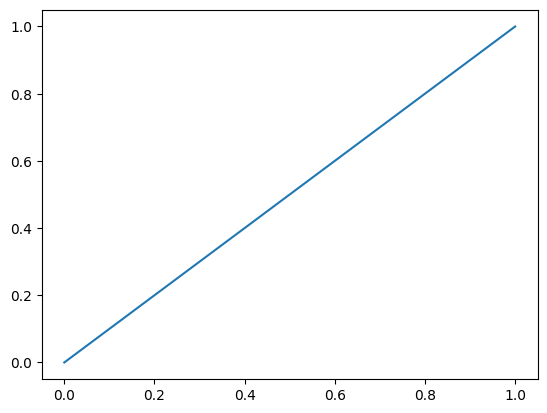

In [2]:
pl.figure()
pl.plot([0,1], [0,1])

